## Dataset Preparation

In [1]:
import numpy as np
import os 
from pathlib import Path
from keras.preprocessing import image
import cv2

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
d = Path("Datasets/Images/")

dirs = d.glob("*")
print(dirs)

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}

image_data = []
labels = []

for folder_dir in dirs:
    print(folder_dir)
    label = str(folder_dir).split("\\")[-1][:-1]
    
    
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])
        

<generator object Path.glob at 0x000001CBBAC57F90>
Datasets\Images\cats
Datasets\Images\dogs
Datasets\Images\horses
Datasets\Images\humans


In [4]:
print(len(image_data))
print(len(labels))

808
808


In [5]:
# Convert this into numpy array
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


### Randomly Shuffle our Data!

In [6]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

#Unzip
image_data[:],labels[:] = zip(*combined)


### Visualise this data!

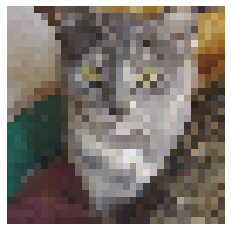

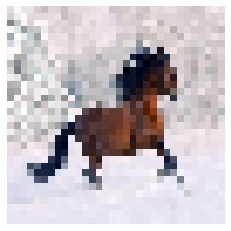

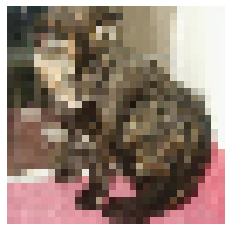

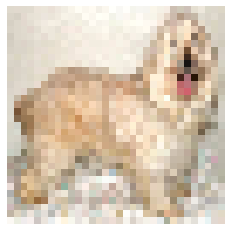

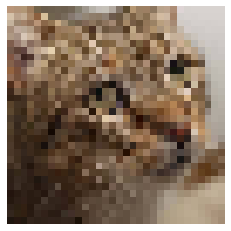

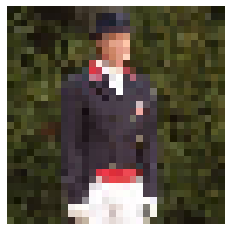

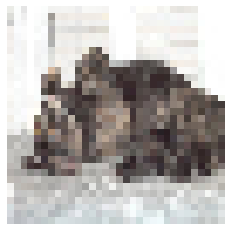

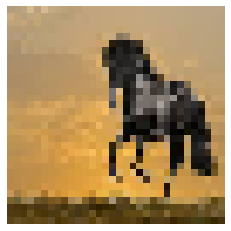

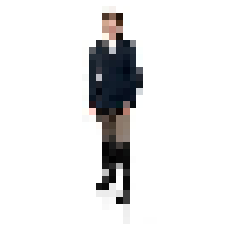

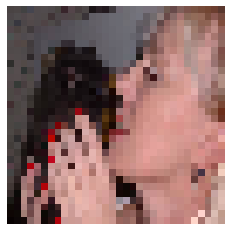

In [7]:
from matplotlib import pyplot as plt

def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    return 

for i in range(10):
    drawImg(image_data[i])

## SVM Classifier

In [8]:
class SVM:

    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

## We need to convert data for One-for-One classifcation!

In [9]:
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [10]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [11]:
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [12]:
data = classWiseData(image_data,labels)

In [13]:
print(data[0].shape)         #Data of cats
print(data[1].shape[0])      #Data of dogs
print(data[2].shape[0])      #Data of horses
print(data[3].shape[0])      #Data of Human being


(202, 3072)
202
202
202


In [14]:
""" GET PAIRWISE DATA """
def getDataPairForSVM(d1,d2):
    """Combines Data of two classes into a signle matrix"""
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels
    

## Training  NC2 SVM's Part!

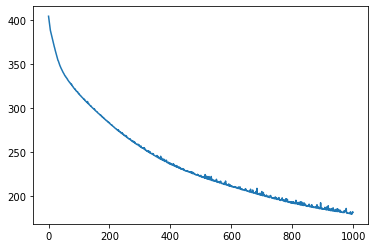

In [15]:
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
#print(loss)
plt.plot(loss)

In [16]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    
    return svm_classifiers

In [17]:
svm_classifiers = trainSVMs(image_data,labels)

In [18]:
#Parameters for Cats and dogs
cats_dogs = svm_classifiers[0][1]
#Parameters for Cats and Horses
cats_horses=svm_classifiers[0][2]
#Parameters for Cats and Humans
cats_humans = svm_classifiers[0][3]
#Parameyers for Dogs and Horses
dogs_horses=svm_classifiers[1][2]
#Parameters for Dogs and Human
dogs_humans=svm_classifiers[1][3]
#Parameters for horses and Human
horse_humans=svm_classifiers[2][3]

print(cats_dogs[0].shape)
print(cats_dogs[1])
print(cats_horses[0].shape)
print(cats_horses[1])
print(cats_humans[0].shape)
print(cats_humans[1])
print(dogs_horses[0].shape)
print(dogs_horses[1])
print(dogs_humans[0].shape)
print(dogs_humans[1])
print(horse_humans[0].shape)
print(horse_humans[1])


(1, 3072)
0.0029400000000000147
(1, 3072)
-0.0969100000000008
(1, 3072)
0.010379999999999993
(1, 3072)
-0.07066999999999968
(1, 3072)
0.030639999999999917
(1, 3072)
0.11169000000000046


## Prediction

In [48]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [49]:
def predict(x):
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [126]:
d=Path("test_images")
for img_path in d.glob("*.jpg"):
    img=image.load_img(img_path,target_size=(32,32))
    img=image.img_to_array(img)
    img=np.array(img,dtype='float32')/255.0
    img=img.reshape(1,-1)
    prediction=predict(img)
    if prediction==0:
        print("Classifier Predicts CAT")
    elif prediction==1:
        print("Classifier Predicts DOG")
    elif prediction==2:
        print("Classifier Predicts HORSE")
    else:
        print("Classifier Predicts Human")



Classifier Predicts CAT
Classifier Predicts CAT
Classifier Predicts CAT
Classifier Predicts CAT
Classifier Predicts DOG
Classifier Predicts DOG
Classifier Predicts HORSE
Classifier Predicts HORSE
Classifier Predicts HORSE
Classifier Predicts HORSE
Classifier Predicts Human
Classifier Predicts Human
Classifier Predicts Human
Classifier Predicts Human
Classifier Predicts Human
Classifier Predicts Human


In [100]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [101]:
accuracy(image_data,labels)

0.5903465346534653

# SVM using SK-learn 



In [75]:
from sklearn import svm

In [76]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)

In [77]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6435643564356436